In [23]:
# !pip install qiskit
# !pip install pylatexenc
# !pip install matplotlib-venn
# !pip install -U -r resources/requirements.txt

import qiskit
print("Qiskit:",qiskit.__qiskit_version__)
from qiskit import *
from qiskit.quantum_info import Statevector 
# from qiskit_textbook.tools import array_to_latex
from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere
from qiskit.visualization import plot_histogram

# find the least busy backend 
# provider = IBMQ.get_provider(hub='ibm-q')
from qiskit.providers.ibmq import least_busy
# backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 2 and
#                                    not b.configuration().simulator and b.status().operational==True))
# job_exp = execute(circuit, backend=backend, shots=1024)
from qiskit.tools.monitor import job_monitor
# job_monitor(job_exp)  # displays job status under cell

from IPython.display import clear_output
clear_output()
from qiskit import Aer
from qiskit.circuit.library import QFT
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms import HHL, NumPyLSsolver
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom
import numpy as np
from IPython.display import clear_output
clear_output()
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.image import ResizeMethod
from scipy import optimize


In [12]:
def evolution(input_dim,reference_dim,thetas,phis,lambdas):
  classical_qubit = ClassicalRegister(1)    ### for swap test
  swap_test_qubit = QuantumRegister(1)      ### for swap test
  input = QuantumRegister(input_dim)
  reference_state = QuantumRegister(reference_dim)

  #intializing circuit
  qc = QuantumCircuit(classical_qubit, swap_test_qubit, reference_state, input)

  para_index=0
  for i in range(input_dim):
    qc.u3(thetas[para_index],phis[para_index],lambdas[para_index], input[i])
    para_index+=1
  qc.barrier()
  
  for i in range(0,input_dim):
    for j in range(0,input_dim):
      if j!=i:
        qc.cu3(thetas[para_index],phis[para_index],lambdas[para_index], input[i], input[j])
        para_index+=1
  qc.barrier()  
  for i in range(input_dim):
    qc.u3(thetas[para_index],phis[para_index],lambdas[para_index], input[i])
    para_index+=1
  ###SWAP test for measuring fidelity
  qc.barrier()
  qc.h(swap_test_qubit)
  for i in range(reference_dim):
    qc.cswap(swap_test_qubit,input[i],reference_state[i])
  qc.h(swap_test_qubit)
  # qc.measure(swap_test_qubit,classical_qubit)
  return qc 

In [13]:
mnist = tf.keras.datasets.mnist # Object of the MNIST dataset
np.random.seed(77)
(x_train, y_train),(x_test, y_test) = mnist.load_data() # Load data
X_batch=tf.reshape(x_train, [-1, 28, 28, 1])

####downscale to 16x16 and convert to blackwhite
h_dim=16
v_dim=16
abc=tf.image.resize(  
    X_batch, [h_dim,v_dim], method=ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None
)

nclasses = np.unique(y_train).size
threshold = 125
def shapex(X):
    return np.where(X<127,0,1)
x_train = np.squeeze(shapex(abc),-1)

# print(np.shape(x_train))
# plt.imshow(x_train[2414], cmap="gray") # Import the image
# plt.show() # Plot the image


In [14]:
def image_to_state_vector(x):
  ''' 16x16 BW image to normalized 256x1 vec
  '''
  state_vector=[]
  for row in x:
    for elt in row:
      state_vector.append(elt)
  return state_vector/np.linalg.norm(state_vector)

def get_init_state(init_sv):
  '''tensor product input with aiding qubits (reference state & swap_test_qubit)
  '''
  state=[]
  for i in range(2**(input_dim+reference_dim+1)):
    if i%(2**(reference_dim+1))==0:
      state.append(init_sv[i//2**(reference_dim+1)])
    else:
      state.append(0)
  state=Statevector(state)
  return state

###get input batch
state_input_batchs = [image_to_state_vector(x) for x in x_train]

# input_dim=8
# reference_dim=2
# thetas = [0]*(input_dim*(input_dim-1)+2*input_dim)
# phis = [0]*(input_dim*(input_dim-1)+2*input_dim)
# lambdas = [0]*(input_dim*(input_dim-1)+2*input_dim)
# mnistU=evolution(input_dim,reference_dim,thetas,phis,lambdas)
# mnistU.draw('mpl',scale=0.5)

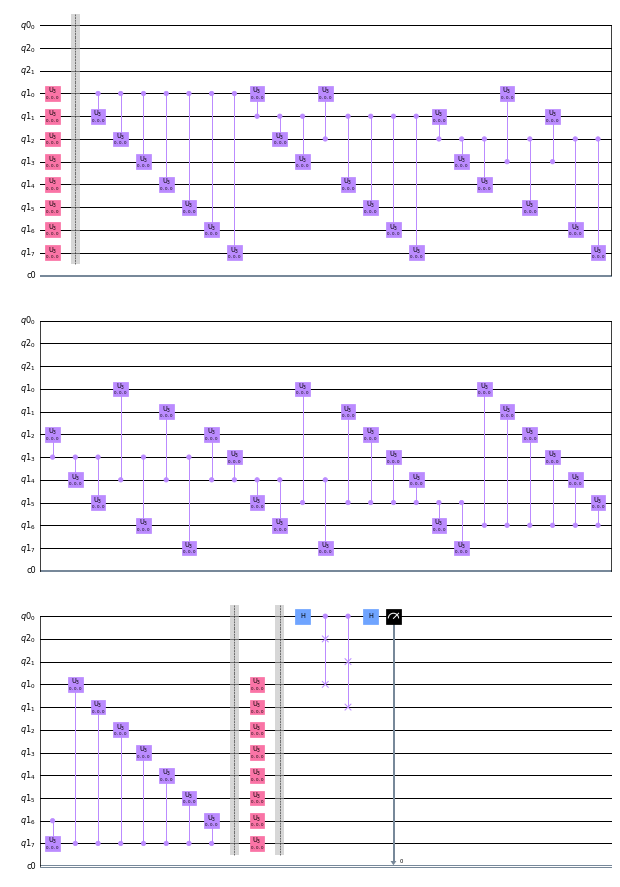

In [ ]:
# np.shape(state_input_batchs[:1000])
# z=get_init_state(state_input_batchs[0])
# final_state=z.evolve(mnistU)
# qiskit.quantum_info.partial_trace(final_state,range(1,input_dim+reference_dim+1))

In [20]:
def calculate_fidelity(x0,training_inputs):
  x0=np.reshape(x0,(3,-1))
  thetas = x0[0]
  phis = x0[1]
  lambdas = x0[2]
  total_error = 0
  mnistU=evolution(input_dim,reference_dim,thetas,phis,lambdas)
  for input_sv in training_inputs:
    state=get_init_state(input_sv)
    final_state=state.evolve(mnistU)     ###evolution
    ##tracing over all except the swap_test_qubit
    p_0=qiskit.quantum_info.partial_trace(final_state,range(1,input_dim+reference_dim+1)).probabilities()[0]  
    # if p_0>1: print(p_0)
    fidel=np.sqrt(max(0,2*p_0-1))
    total_error +=(1-fidel)
  total_error /= training_inputs.shape[0]
  print("\b obj:",total_error)
  return total_error

In [21]:
input_dim=8
reference_dim=2
n_para = (input_dim*(input_dim-1)+2*input_dim)*3
dim_state = 2**input_dim
x0 = np.random.uniform(np.pi,np.pi*3,n_para)

In [30]:
minimizer_kwargs ={
    "method" : "L-BFGS-B",
    "args"   : np.array(state_input_batchs[:90]),
    "bounds" : optimize.Bounds(0,4*np.pi),
    "options": {"iprint" : 100, "maxls": 15, "disp": True}
}

In [ ]:
# calculate_fidelity(x0, np.array(state_input_batchs[:1000]))
local_mins =[]

def record_local_mins(x,f,accept):
    local_mins.append((x,f))
    print("x:")
    print(x)
ret = optimize.basinhopping(calculate_fidelity, x0, minimizer_kwargs=minimizer_kwargs,
                   niter=30,disp=True,niter_success=10,callback=record_local_mins)

Streaming output truncated to the last 5000 lines.
 obj: 0.17866459393820158
 obj: 0.17866459393230005
 obj: 0.1786645939336499
 obj: 0.1786645939326759
 obj: 0.17866459393842885
 obj: 0.17866459394291098
 obj: 0.1786645939367074
 obj: 0.1786645939411062
 obj: 0.17866459393518658
 obj: 0.17866459393499487
 obj: 0.17866459394577766
 obj: 0.17866459393877676
 obj: 0.17866459394394701
 obj: 0.17866459394043058
 obj: 0.17866459394121853
 obj: 0.17866459394165513
 obj: 0.17866459394415704
 obj: 0.17866459394314158
 obj: 0.17866459393627632
 obj: 0.17866459393641246
 obj: 0.17866459394043324
 obj: 0.1786645939382058
 obj: 0.17866459393845868
 obj: 0.1786645939408909
 obj: 0.17866459393695056
 obj: 0.17866459393957942
 obj: 0.17866459393727507
 obj: 0.17866459394060835
 obj: 0.17866459393839326
 obj: 0.17866459393699613
 obj: 0.17866459393901835
 obj: 0.17866459393377027
 obj: 0.17866459393396902
 obj: 0.17866459394062298
 obj: 0.17866459394162865
 obj: 0.1